In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import findspark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession


findspark.init('C:/Users/Ben/spark-3.5.0-bin-hadoop3')

# SECTION 1 Dataset Descriptions

## 1.1 Customer Data

In [14]:
#read data to dataframe
custdf = pd.read_csv('train_customers.csv')
custdf.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


In [3]:
#description of data
custdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   akeed_customer_id  34674 non-null  object 
 1   gender             22520 non-null  object 
 2   dob                3046 non-null   float64
 3   status             34674 non-null  int64  
 4   verified           34674 non-null  int64  
 5   language           21099 non-null  object 
 6   created_at         34674 non-null  object 
 7   updated_at         34674 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.1+ MB


In [15]:
#read test data
custtest = pd.read_csv('test_customers.csv')
custtest.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36
1,FWNUI71,Male,NaN,1,1,EN,2018-03-22 20:11:47,2018-03-22 20:11:47
2,LRX7BCH,Male,NaN,1,1,EN,2018-04-17 20:01:15,2018-04-17 20:01:15
3,D96DHMD,Male,NaN,1,1,EN,2018-04-29 22:35:52,2018-04-29 22:35:52
4,88Q8Y5V,Male,1997.0,1,1,EN,2018-05-05 12:38:09,2018-05-05 12:38:09


In [117]:
#checking similarity with train data
custtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9768 entries, 0 to 9767
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   akeed_customer_id  9768 non-null   object 
 1   gender             6321 non-null   object 
 2   dob                848 non-null    float64
 3   status             9768 non-null   int64  
 4   verified           9768 non-null   int64  
 5   language           5928 non-null   object 
 6   created_at         9768 non-null   object 
 7   updated_at         9768 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 610.6+ KB


test data has the same features as the train data

## 1.2 Location Data

In [16]:
#read data to dataframe
locdf = pd.read_csv('train_locations.csv')
locdf.head()

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


In [5]:
#description of data
locdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59503 entries, 0 to 59502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      59503 non-null  object 
 1   location_number  59503 non-null  int64  
 2   location_type    32294 non-null  object 
 3   latitude         59497 non-null  float64
 4   longitude        59497 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB


In [17]:
#read test data
loctest = pd.read_csv('test_locations.csv')
loctest.head()

,customer_id,location_number,location_type,latitude,longitude
0,Z59FTQD,0,NaN,126.032278,-9.106019
1,0JP29SK,0,Home,0.278709,-78.623847
2,0JP29SK,1,Home,0.124485,-78.605621
3,0JP29SK,2,NaN,-0.113891,-78.577449
4,0JP29SK,3,NaN,-0.848796,0.136726


In [15]:
#checking similarity with train data
loctest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16720 entries, 0 to 16719
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      16720 non-null  object 
 1   location_number  16720 non-null  int64  
 2   location_type    9070 non-null   object 
 3   latitude         16717 non-null  float64
 4   longitude        16717 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 653.3+ KB


## 1.3 Vendor Data

In [277]:
#read data to dataframe
vendf = pd.read_csv('vendors.csv')
vendf.head()

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [9]:
#description of data
vendf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    int64  
 1   authentication_id     100 non-null    float64
 2   latitude              100 non-null    float64
 3   longitude             100 non-null    float64
 4   vendor_category_en    100 non-null    object 
 5   vendor_category_id    100 non-null    float64
 6   delivery_charge       100 non-null    float64
 7   serving_distance      100 non-null    float64
 8   is_open               100 non-null    float64
 9   OpeningTime           91 non-null     object 
 10  OpeningTime2          91 non-null     object 
 11  prepration_time       100 non-null    int64  
 12  commission            85 non-null     float64
 13  is_akeed_delivering   100 non-null    object 
 14  discount_percentage   100 non-null    float64
 15  status                10

## 1.4 Order Data

In [19]:
#read data to dataframe
order_df = pd.read_csv('orders.csv', low_memory=False)
order_df.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [13]:
#description of data
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   akeed_order_id                  135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  vendor_rating                   45220 non-null   float64
 11  driver_rating                   135303 non-null  float64
 12  deliverydistance

## 1.5 Full Data

In [8]:
#read data to dataframe
full_df = pd.read_csv('train_full.csv', low_memory=False)
full_df.head()

,customer_id,gender,status_x,verified_x,created_at_x,updated_at_x,location_number,location_type,latitude_x,longitude_x,...,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,target
0,TCHWPBT,Male,1,1,2018-02-07 19:16:23,2018-02-07 19:16:23,0,Work,-96.44,-67.2,...,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1,0,4,TCHWPBT X 0 X 4,0
1,TCHWPBT,Male,1,1,2018-02-07 19:16:23,2018-02-07 19:16:23,0,Work,-96.44,-67.2,...,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1,0,13,TCHWPBT X 0 X 13,0
2,TCHWPBT,Male,1,1,2018-02-07 19:16:23,2018-02-07 19:16:23,0,Work,-96.44,-67.2,...,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1,0,20,TCHWPBT X 0 X 20,0
3,TCHWPBT,Male,1,1,2018-02-07 19:16:23,2018-02-07 19:16:23,0,Work,-96.44,-67.2,...,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1,0,23,TCHWPBT X 0 X 23,0
4,TCHWPBT,Male,1,1,2018-02-07 19:16:23,2018-02-07 19:16:23,0,Work,-96.44,-67.2,...,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1,0,28,TCHWPBT X 0 X 28,0


In [6]:
#target variable in full dataset
full_df[['CID X LOC_NUM X VENDOR', 'target']]

,CID X LOC_NUM X VENDOR,target
0,TCHWPBT X 0 X 4,0
1,TCHWPBT X 0 X 13,0
2,TCHWPBT X 0 X 20,0
3,TCHWPBT X 0 X 23,0
4,TCHWPBT X 0 X 28,0
...,...,...
5802395,LBMRK7A X 0 X 849,0
5802396,LBMRK7A X 0 X 855,0
5802397,LBMRK7A X 0 X 856,0
5802398,LBMRK7A X 0 X 858,0


In [7]:
#description of data
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802400 entries, 0 to 5802399
Data columns (total 73 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   customer_id             object 
 1   gender                  object 
 2   status_x                int64  
 3   verified_x              int64  
 4   created_at_x            object 
 5   updated_at_x            object 
 6   location_number         int64  
 7   location_type           object 
 8   latitude_x              float64
 9   longitude_x             float64
 10  id                      int64  
 11  authentication_id       float64
 12  latitude_y              float64
 13  longitude_y             float64
 14  vendor_category_en      object 
 15  vendor_category_id      float64
 16  delivery_charge         float64
 17  serving_distance        float64
 18  is_open                 float64
 19  OpeningTime             object 
 20  OpeningTime2            object 
 21  prepration_time         int64  

the features are from other datasets except for the target variable

In [16]:
#read test data
fulltest = pd.read_csv('test_full.csv', low_memory=False)
fulltest.head()

,customer_id,gender,status_x,verified_x,created_at_x,updated_at_x,location_number,location_type,latitude_x,longitude_x,...,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,location_number_obj,id_obj,CID X LOC_NUM X VENDOR
0,ICE2DJP,Male,1.0,1.0,2018-02-07 16:45:36,2018-02-07 16:45:36,0.0,NaN,-96.44,-67.2,...,Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3.0,1.0,0.0,4.0,ICE2DJP X 0 X 4
1,ICE2DJP,Male,1.0,1.0,2018-02-07 16:45:36,2018-02-07 16:45:36,0.0,NaN,-96.44,-67.2,...,Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3.0,1.0,0.0,13.0,ICE2DJP X 0 X 13
2,ICE2DJP,Male,1.0,1.0,2018-02-07 16:45:36,2018-02-07 16:45:36,0.0,NaN,-96.44,-67.2,...,Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3.0,1.0,0.0,20.0,ICE2DJP X 0 X 20
3,ICE2DJP,Male,1.0,1.0,2018-02-07 16:45:36,2018-02-07 16:45:36,0.0,NaN,-96.44,-67.2,...,Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3.0,1.0,0.0,23.0,ICE2DJP X 0 X 23
4,ICE2DJP,Male,1.0,1.0,2018-02-07 16:45:36,2018-02-07 16:45:36,0.0,NaN,-96.44,-67.2,...,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3.0,1.0,0.0,28.0,ICE2DJP X 0 X 28


In [17]:
#checking similarity with train data
fulltest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672000 entries, 0 to 1671999
Data columns (total 72 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1631700 non-null  object 
 1   gender                  1152000 non-null  object 
 2   status_x                1631700 non-null  float64
 3   verified_x              1631700 non-null  float64
 4   created_at_x            1631700 non-null  object 
 5   updated_at_x            1631700 non-null  object 
 6   location_number         1631700 non-null  float64
 7   location_type           885600 non-null   object 
 8   latitude_x              1631400 non-null  float64
 9   longitude_x             1631400 non-null  float64
 10  id                      1631700 non-null  float64
 11  authentication_id       1631700 non-null  float64
 12  latitude_y              1631700 non-null  float64
 13  longitude_y             1631700 non-null  float64
 14  ve

# SECTION 2 Exploratory Data Analysis

## 2.1 Customer Data

In [14]:
#missing value in customer data
print("Customer data missing values")
custdf.isna().sum()

Customer data missing values


akeed_customer_id        0
gender               12154
dob                  31628
status                   0
verified                 0
language             13575
created_at               0
updated_at               0
dtype: int64

In [13]:
#percentage of NaN in dob data
print(round(custdf.dob.isna().sum()/len(custdf)*100), "%")

91 %


dob data has too much missing values

In [20]:
#count of genders
custdf.gender.value_counts()

gender
Male          17815
male           2914
Female         1761
Female           13
Male              9
Female            2
Female            2
?????             2
Female            1
                  1
Name: count, dtype: int64

In [19]:
custdf.gender.unique()

array(['Male', 'Female', 'Female  ', 'Female   ', 'Female    ', 'Male  ',
       '  ', 'Female ', nan, '?????', 'male'], dtype=object)

genders need to be fixed

In [22]:
#check language column value
custdf.language.value_counts()

language
EN    21099
Name: count, dtype: int64

In [35]:
#status of customers
print(custdf.status.value_counts())
print(custdf.verified.value_counts())

status
1    34639
0       35
Name: count, dtype: int64
verified
1    33167
0     1507
Name: count, dtype: int64


In [30]:
#records of customers
custdf[['created_at', 'updated_at']]

,created_at,updated_at
0,2018-02-07 19:16:23,2018-02-07 19:16:23
1,2018-02-09 12:04:42,2018-02-09 12:04:41
2,2018-03-14 18:31:43,2018-03-14 18:31:42
3,2018-03-15 19:47:07,2018-03-15 19:47:07
4,2018-03-15 19:57:01,2018-03-15 19:57:01
...,...,...
34669,2020-03-03 13:01:13,2020-03-03 13:02:21
34670,2020-03-03 13:22:35,2020-03-03 13:22:41
34671,2020-03-03 13:24:27,2020-03-03 13:24:44
34672,2020-03-03 13:24:28,2020-03-03 13:28:00


## 2.2 Location Data

In [37]:
locdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59503 entries, 0 to 59502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      59503 non-null  object 
 1   location_number  59503 non-null  int64  
 2   location_type    32294 non-null  object 
 3   latitude         59497 non-null  float64
 4   longitude        59497 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB


In [43]:
#number of locations of customers
print('location number')
locdf.location_number.unique()

location number


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

In [38]:
#count of location numbers
locdf.location_number.value_counts()

location_number
0     35400
1     13798
2      5488
3      2519
4      1153
5       504
6       246
7       128
8        76
9        52
10       34
11       21
12       15
13       13
14       13
15        8
16        6
17        5
18        5
19        3
20        2
21        2
22        2
23        2
24        2
25        2
26        1
27        1
28        1
29        1
Name: count, dtype: int64

In [42]:
#checking customers with 30 locations
locdf[locdf.location_number == 29]

,customer_id,location_number,location_type,latitude,longitude
56039,4Y0K8NQ,29,Home,126.618168,-9.374296


In [40]:
locdf[locdf.customer_id == '4Y0K8NQ']

,customer_id,location_number,location_type,latitude,longitude
56010,4Y0K8NQ,0,Home,0.041898,0.459054
56011,4Y0K8NQ,1,NaN,19.706231,3.037813
56012,4Y0K8NQ,2,Home,126.357991,-9.225567
56013,4Y0K8NQ,3,Home,-14.616677,-3.310623
56014,4Y0K8NQ,4,Home,125.277096,-9.128956
56015,4Y0K8NQ,5,Home,126.560174,-9.420703
56016,4Y0K8NQ,6,Home,-0.178036,0.492985
56017,4Y0K8NQ,7,Home,-96.407541,43.557974
56018,4Y0K8NQ,8,Home,0.009044,0.544473
56019,4Y0K8NQ,9,Home,-96.672983,43.555452


In [44]:
#missing values in location
locdf.isna().sum()

customer_id            0
location_number        0
location_type      27209
latitude               6
longitude              6
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

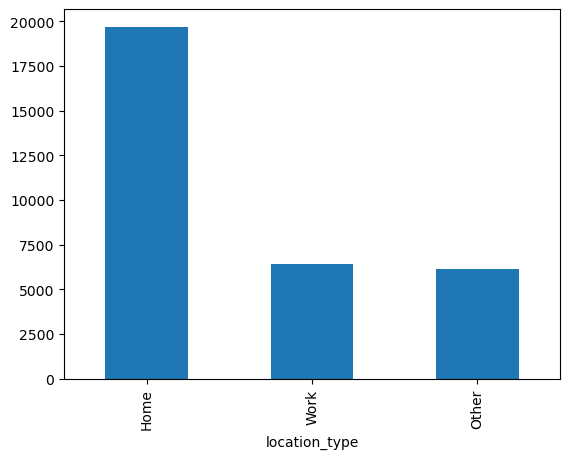

In [47]:
#value counts of location type
locdf.location_type.value_counts().plot(kind='bar')
plt.show

most order location are from home

In [48]:
locdf.location_type.unique()

array([nan, 'Home', 'Work', 'Other'], dtype=object)

## 2.3 Orders Data

In [52]:
#checking columns in order
order_df.columns

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')

In [46]:
#checking columns in full data to compare
full_df.columns

Index(['customer_id', 'gender', 'status_x', 'verified_x', 'created_at_x',
       'updated_at_x', 'location_number', 'location_type', 'latitude_x',
       'longitude_x', 'id', 'authentication_id', 'latitude_y', 'longitude_y',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_akeed_delivering',
       'discount_percentage', 'status_y', 'verified_y', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2',
       

most columns in order dataset is not used in full dataset

In [55]:
#missing values in order
order_df.isna().sum()

akeed_order_id                        70
customer_id                            0
item_count                          6925
grand_total                            0
payment_mode                           0
promo_code                        130998
vendor_discount_amount                 0
promo_code_discount_percentage     69423
is_favorite                        35195
is_rated                               0
vendor_rating                      90083
driver_rating                          0
deliverydistance                       0
preparationtime                    55560
delivery_time                     130180
order_accepted_time                48348
driver_accepted_time               88845
ready_for_pickup_time              51054
picked_up_time                     51438
delivered_time                     49562
delivery_date                      99759
vendor_id                              0
created_at                             0
LOCATION_NUMBER                        0
LOCATION_TYPE   

In [49]:
#checking customer orders
order_df[order_df.customer_id == '4Y0K8NQ']

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
84440,300538.0,4Y0K8NQ,1.0,5.4,1,NaN,0.0,0.0,No,Yes,...,NaN,2019-12-17 16:11:16,2019-12-17 16:34:16,2019-12-17 16:43:17,NaN,157,2019-12-17 16:10:28,6,Home,4Y0K8NQ X 6 X 157
92830,317594.0,4Y0K8NQ,1.0,7.0,2,NaN,0.0,0.0,No,No,...,2019-12-30 20:21:29,2019-12-30 20:14:17,NaN,NaN,NaN,841,2019-12-30 20:13:42,9,Home,4Y0K8NQ X 9 X 841
92837,317605.0,4Y0K8NQ,1.0,10.7,1,NaN,0.0,0.0,No,No,...,2019-12-30 20:56:39,2019-12-30 20:22:13,NaN,NaN,NaN,846,2019-12-30 20:21:43,9,Home,4Y0K8NQ X 9 X 846
92882,317673.0,4Y0K8NQ,1.0,11.0,1,NaN,0.0,0.0,No,No,...,NaN,2019-12-30 20:46:33,NaN,NaN,NaN,858,2019-12-30 20:46:10,9,Home,4Y0K8NQ X 9 X 858
93188,318271.0,4Y0K8NQ,1.0,2.4,1,NaN,0.0,0.0,No,No,...,NaN,NaN,NaN,NaN,NaN,841,2019-12-31 11:06:47,9,Home,4Y0K8NQ X 9 X 841
93189,318272.0,4Y0K8NQ,1.0,2.7,2,NaN,0.0,0.0,No,No,...,NaN,NaN,NaN,NaN,NaN,846,2019-12-31 11:08:09,9,Home,4Y0K8NQ X 9 X 846
93191,318277.0,4Y0K8NQ,1.0,2.4,1,NaN,0.0,0.0,No,No,...,NaN,NaN,NaN,NaN,NaN,858,2019-12-31 11:13:18,9,Home,4Y0K8NQ X 9 X 858
93240,318400.0,4Y0K8NQ,1.0,11.0,1,NaN,0.0,0.0,No,No,...,2019-12-31 13:05:12,2019-12-31 13:00:48,NaN,NaN,NaN,841,2019-12-31 12:58:31,9,Home,4Y0K8NQ X 9 X 841
93304,318551.0,4Y0K8NQ,1.0,8.1,1,NaN,0.0,0.0,No,No,...,NaN,2019-12-31 14:19:54,NaN,NaN,NaN,858,2019-12-31 14:18:16,9,Home,4Y0K8NQ X 9 X 858
93389,318710.0,4Y0K8NQ,1.0,8.6,1,NaN,0.0,0.0,No,No,...,2019-12-31 16:11:22,2019-12-31 16:08:07,NaN,NaN,NaN,846,2019-12-31 16:06:28,9,Home,4Y0K8NQ X 9 X 846


In [50]:
#features for the target variable
order_df[['customer_id', 'vendor_id', 'LOCATION_NUMBER', 'CID X LOC_NUM X VENDOR']]

,customer_id,vendor_id,LOCATION_NUMBER,CID X LOC_NUM X VENDOR
0,92PEE24,105,0,92PEE24 X 0 X 105
1,QS68UD8,294,0,QS68UD8 X 0 X 294
2,MB7VY5F,83,0,MB7VY5F X 0 X 83
3,KDJ951Y,90,0,KDJ951Y X 0 X 90
4,BAL0RVT,83,0,BAL0RVT X 0 X 83
...,...,...,...,...
135298,L6LFY6H,67,0,L6LFY6H X 0 X 67
135299,2GMMVGI,79,0,2GMMVGI X 0 X 79
135300,LYTAAV0,28,2,LYTAAV0 X 2 X 28
135301,NEV9A5D,841,0,NEV9A5D X 0 X 841


## 2.4 Vendors Data

In [64]:
#check missing values in vendors
vendf.isna().sum()

id                       0
authentication_id        0
latitude                 0
longitude                0
vendor_category_en       0
vendor_category_id       0
delivery_charge          0
serving_distance         0
is_open                  0
OpeningTime              9
OpeningTime2             9
prepration_time          0
commission              15
is_akeed_delivering      0
discount_percentage      0
status                   0
verified                 0
rank                     0
language                15
vendor_rating            0
sunday_from_time1        1
sunday_to_time1          1
sunday_from_time2       58
sunday_to_time2         58
monday_from_time1        0
monday_to_time1          0
monday_from_time2       58
monday_to_time2         58
tuesday_from_time1       1
tuesday_to_time1         1
tuesday_from_time2      59
tuesday_to_time2        59
wednesday_from_time1     0
wednesday_to_time1       0
wednesday_from_time2    58
wednesday_to_time2      58
thursday_from_time1      1
t

In [38]:
#check the values in each column
for i in vendf.columns:
    print(i, vendf[i].unique())

id [  4  13  20  23  28  33  43  44  55  66  67  75  76  78  79  81  82  83
  84  85  86  90  92 104 105 106 110 113 115 134 145 148 149 154 157 159
 160 161 176 180 188 189 191 192 193 195 196 197 199 201 203 207 216 221
 225 231 237 243 250 259 265 271 274 288 289 294 295 298 299 300 303 304
 310 356 386 391 398 401 419 459 537 547 573 575 577 578 582 583 676 679
 681 841 843 845 846 849 855 856 858 907]
authentication_id [118597. 118608. 118616. 118619. 118624. 118629. 118639. 118640. 118651.
 118662. 118663. 118672. 118673. 118675. 118676. 118678. 118679. 118680.
 118681. 118682. 118683. 118687. 118689. 118701. 118702. 118703. 118707.
 118710. 118712. 118731. 118742. 118745. 118746. 118752. 118755. 118757.
 118758. 118759. 118774. 118778. 118786. 118787. 118789. 118790. 118791.
 118793. 118794. 118795. 118798. 118800. 118802. 118806. 118815. 118820.
 118824. 118830. 118838. 118844. 118851. 118860. 118866. 118872. 118875.
 118889. 118890. 118896. 118897. 118900. 118901. 118902. 1189

In [41]:
#column with only one value exclude NaN
for i in vendf.columns:
    df = vendf[i].dropna()
    if len(df.unique()) == 1:
        print(i, df.unique())

commission [0.]
is_akeed_delivering ['Yes']
language ['EN']
open_close_flags [1.]
one_click_vendor ['Y']
country_id [1.]
city_id [1.]
display_orders [1]


In [63]:
#checking vendor opening time
vendf[['OpeningTime']].head(5)

,OpeningTime
0,11:00AM-11:30PM
1,08:30AM-10:30PM
2,08:00AM-10:45PM
3,10:59AM-10:30PM
4,11:00AM-11:45PM


In [61]:
#comparing values in opening time and time each day
vendf.loc[:,'sunday_from_time1':'saturday_to_time2'].head(5)

,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,...,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2
0,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,...,08:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00
1,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,...,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00
2,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,...,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN
3,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,...,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN
4,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,...,11:00:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00


In [278]:
#checking the category value
vendf[['vendor_category_en', 'vendor_category_id']].drop_duplicates()

,vendor_category_en,vendor_category_id
0,Restaurants,2.0
19,Sweets & Bakes,3.0
28,Sweets & Bakes,2.0


there are two categories but the vendor_category_id has some wrong values

<function matplotlib.pyplot.show(close=None, block=None)>

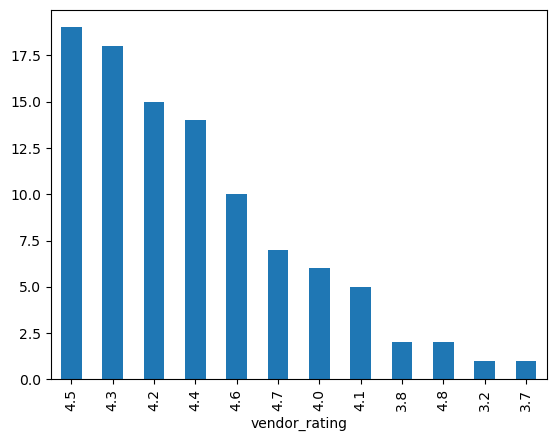

In [279]:
#plotting vendor rating
vendf.vendor_rating.value_counts().plot(kind='bar')
plt.show

most vendors have rating above 4 out of 5

In [44]:
#checking vendor tags
vendf.loc[:,['primary_tags', 'vendor_tag', 'vendor_tag_name']]

,primary_tags,vendor_tag,vendor_tag_name
0,"{""primary_tags"":""4""}","2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver..."
1,"{""primary_tags"":""7""}","4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa..."
2,"{""primary_tags"":""71""}","4,8,91,10","Breakfast,Desserts,Free Delivery,Indian"
3,"{""primary_tags"":""46""}","5,8,30,24","Burgers,Desserts,Fries,Salads"
4,"{""primary_tags"":""32""}",5,Burgers
...,...,...,...
95,"{""primary_tags"":""2396""}","1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ..."
96,"{""primary_tags"":""2396""}","1,5,8,91,30,48,24","American,Burgers,Desserts,Free Delivery,Fries,..."
97,"{""primary_tags"":""2396""}","1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ..."
98,"{""primary_tags"":""2396""}","1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ..."


primary tags have different values with the two other columns. Vendor tag and vendor tag name values are the same

<function matplotlib.pyplot.show(close=None, block=None)>

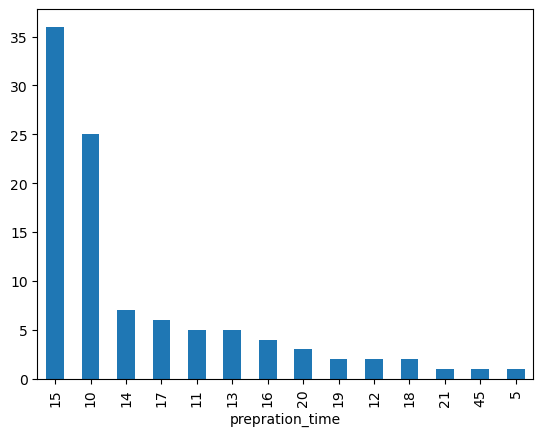

In [7]:
#plotting preparation time
vendf.prepration_time.value_counts().plot(kind='bar')
plt.show

[[<Axes: title={'center': 'prepration_time'}>]]


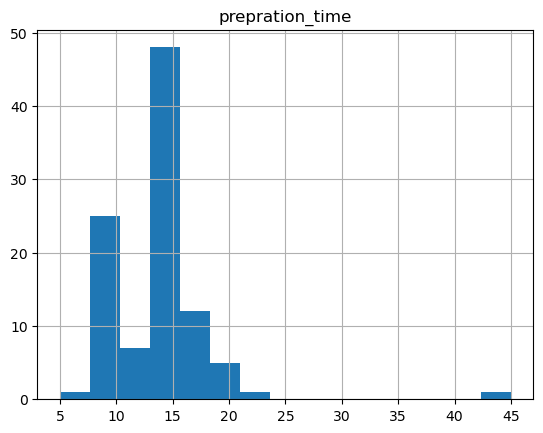

In [8]:
#histogram of preparation time
hist_ven = vendf.hist(column='prepration_time', bins=15)
print(hist_ven)

average preparation time is 15 minutes with an outlier of 45 minutes

[[<Axes: title={'center': 'vendor_rating'}>]]


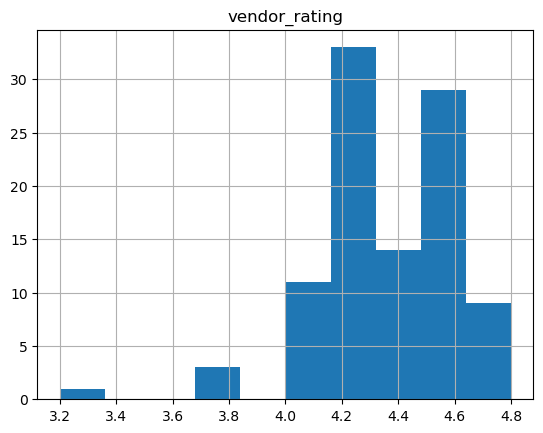

In [8]:
#histogram of vendor rating
hist_ven = vendf.hist(column='vendor_rating', bins=10)
print(hist_ven)

<function matplotlib.pyplot.show(close=None, block=None)>

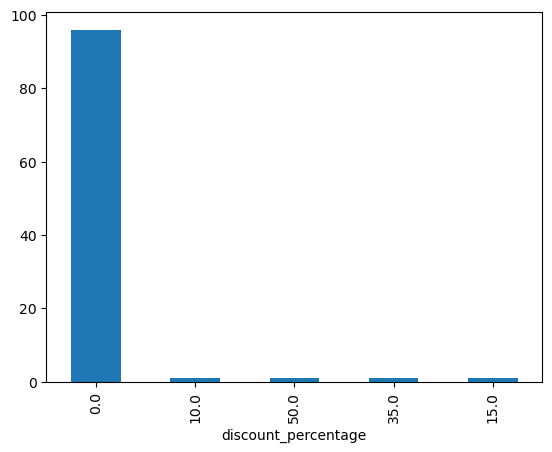

In [65]:
#plotting discount percentage
vendf.discount_percentage.value_counts().plot(kind='bar')
plt.show

In [91]:
#check vendors status
print(vendf.status.value_counts(), vendf.verified.value_counts())

status
1.0    85
0.0    15
Name: count, dtype: int64 verified
1    88
0    12
Name: count, dtype: int64


most vendors are verified

## 2.5 Full Data

In [70]:
full_df.columns

Index(['customer_id', 'gender', 'status_x', 'verified_x', 'created_at_x',
       'updated_at_x', 'location_number', 'location_type', 'latitude_x',
       'longitude_x', 'id', 'authentication_id', 'latitude_y', 'longitude_y',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_akeed_delivering',
       'discount_percentage', 'status_y', 'verified_y', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2',
       

In [74]:
#create new dataframe to filter data with order (target = 1) for analyses
full_df2 = full_df[full_df.target == 1]

In [75]:
#checking number of orders with different discounts
full_df2.discount_percentage.value_counts()

discount_percentage
0.0     75027
50.0     1482
35.0      764
15.0      618
10.0      363
Name: count, dtype: int64

In [86]:
#checking number of orders with and without delivery charge
full_df2.delivery_charge.value_counts()

delivery_charge
0.0    39458
0.7    38796
Name: count, dtype: int64

In [87]:
#checking serving distance of each vendor
full_df2[['id', 'serving_distance']].drop_duplicates()

,id,serving_distance
56,237,15.0
227,113,15.0
362,274,15.0
370,303,15.0
404,28,15.0
...,...,...
111976,398,15.0
134896,855,8.0
138448,199,15.0
152964,289,15.0


In [85]:
#checking serving distance of a vendor
full_df2[['customer_id', 'location_number', 'id', 'serving_distance']][full_df2.id == 237]

,customer_id,location_number,id,serving_distance
56,TCHWPBT,0,237,15.0
32856,ZMD2BCF,4,237,15.0
42356,XIHMYYC,0,237,15.0
45656,XHVKVAR,1,237,15.0
55256,JNVC68C,0,237,15.0
...,...,...,...,...
5726056,G3H8X19,0,237,15.0
5731056,GWAS28K,0,237,15.0
5743656,F00NSXB,0,237,15.0
5795456,VRO3FJA,0,237,15.0


In [89]:
#checking other features values
full_df2[['location_number','id','location_number_obj', 'id_obj']]

,location_number,id,location_number_obj,id_obj
56,0,237,0,237
227,2,113,2,113
362,0,274,0,274
370,0,303,0,303
404,1,28,1,28
...,...,...,...,...
5800578,0,419,0,419
5800799,0,907,0,907
5800995,0,849,0,849
5801718,0,84,0,84


In [94]:
#check vendor status
full_df2.status_y.value_counts()

status_y
1.0    67785
0.0    10469
Name: count, dtype: int64

In [95]:
#check target variable
full_df.target.value_counts()

target
0    5724146
1      78254
Name: count, dtype: int64

the target variable is highly imbalanced

# SECTION 3 Data Preparation

## 3.1 Recreate Full Data

In [18]:
#checking the number of each customer data
print(len(custdf.akeed_customer_id.unique()))
print(len(order_df.customer_id.unique()))

34523
27445


the difference in number meaning there are customers without order records. These customers will be excluded

In [20]:
#new dataframe for only customer id in order
ordercust = pd.DataFrame(order_df.customer_id.unique(), columns=['customer_id'])

#merge customer on order and customer data
newfull = ordercust.merge(custdf, how='inner', left_on='customer_id', right_on='akeed_customer_id')
newfull.head()

,customer_id,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07
1,QS68UD8,QS68UD8,NaN,NaN,1,1,EN,2019-08-09 00:57:11,2019-10-01 18:53:22
2,MB7VY5F,MB7VY5F,NaN,NaN,1,1,EN,2019-07-03 14:25:10,2019-10-01 18:49:08
3,KDJ951Y,KDJ951Y,Male,NaN,1,1,EN,2019-01-04 21:33:08,2019-01-04 21:33:08
4,BAL0RVT,BAL0RVT,Male,NaN,1,1,EN,2018-10-16 20:44:27,2018-10-16 20:44:26


In [20]:
newfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26873 entries, 0 to 26872
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        26873 non-null  object 
 1   akeed_customer_id  26873 non-null  object 
 2   gender             18644 non-null  object 
 3   dob                2404 non-null   float64
 4   status             26873 non-null  int64  
 5   verified           26873 non-null  int64  
 6   language           18115 non-null  object 
 7   created_at         26873 non-null  object 
 8   updated_at         26873 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 1.8+ MB


the rows even less than the record from order data, meaning there are also customers in order data without records in customer data

In [21]:
#merge data with location
newfull = newfull.merge(locdf, how='left', left_on='akeed_customer_id', right_on='customer_id')
newfull.head()

,customer_id_x,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at,customer_id_y,location_number,location_type,latitude,longitude
0,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,0,NaN,-0.132100,-78.575297
1,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,1,Home,-0.760509,-78.501031
2,QS68UD8,QS68UD8,NaN,NaN,1,1,EN,2019-08-09 00:57:11,2019-10-01 18:53:22,QS68UD8,0,Work,-0.393396,-78.544417
3,QS68UD8,QS68UD8,NaN,NaN,1,1,EN,2019-08-09 00:57:11,2019-10-01 18:53:22,QS68UD8,1,NaN,-1.180807,-0.073150
4,MB7VY5F,MB7VY5F,NaN,NaN,1,1,EN,2019-07-03 14:25:10,2019-10-01 18:49:08,MB7VY5F,0,NaN,-1.072823,-78.464121


In [11]:
newfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49314 entries, 0 to 49313
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id_x      49314 non-null  object 
 1   akeed_customer_id  49314 non-null  object 
 2   gender             36573 non-null  object 
 3   dob                4448 non-null   float64
 4   status             49314 non-null  int64  
 5   verified           49314 non-null  int64  
 6   language           38757 non-null  object 
 7   created_at         49314 non-null  object 
 8   updated_at         49314 non-null  object 
 9   customer_id_y      49314 non-null  object 
 10  location_number    49314 non-null  int64  
 11  location_type      27325 non-null  object 
 12  latitude           49308 non-null  float64
 13  longitude          49308 non-null  float64
dtypes: float64(3), int64(3), object(8)
memory usage: 5.3+ MB


In [12]:
newfull.isna().sum()

customer_id_x            0
akeed_customer_id        0
gender               12741
dob                  44866
status                   0
verified                 0
language             10557
created_at               0
updated_at               0
customer_id_y            0
location_number          0
location_type        21989
latitude                 6
longitude                6
dtype: int64

In [22]:
#merge data with vendor
newfull = newfull.merge(vendf, how='cross')
newfull.head(5)

,customer_id_x,akeed_customer_id,gender,dob,status_x,verified_x,language_x,created_at_x,updated_at_x,customer_id_y,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders
0,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [23]:
newfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931400 entries, 0 to 4931399
Data columns (total 73 columns):
 #   Column                Dtype  
---  ------                -----  
 0   customer_id_x         object 
 1   akeed_customer_id     object 
 2   gender                object 
 3   dob                   float64
 4   status_x              int64  
 5   verified_x            int64  
 6   language_x            object 
 7   created_at_x          object 
 8   updated_at_x          object 
 9   customer_id_y         object 
 10  location_number       int64  
 11  location_type         object 
 12  latitude_x            float64
 13  longitude_x           float64
 14  id                    int64  
 15  authentication_id     float64
 16  latitude_y            float64
 17  longitude_y           float64
 18  vendor_category_en    object 
 19  vendor_category_id    float64
 20  delivery_charge       float64
 21  serving_distance      float64
 22  is_open               float64
 23  Opening

the recreated full data has less records

In [24]:
#adding the combined id column
newfull.loc[:, 'CID X LOC_NUM X VENDOR'] = newfull['akeed_customer_id'].astype(str) + " X " + newfull['location_number'].astype(str) + " X " + newfull['id'].astype(str)
newfull.head()

,customer_id_x,akeed_customer_id,gender,dob,status_x,verified_x,language_x,created_at_x,updated_at_x,customer_id_y,...,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,CID X LOC_NUM X VENDOR
0,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1,92PEE24 X 0 X 4
1,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1,92PEE24 X 0 X 13
2,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1,92PEE24 X 0 X 20
3,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1,92PEE24 X 0 X 23
4,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1,92PEE24 X 0 X 28


In [25]:
#create dictionary to map order data
orderdict = pd.Series([1]*len(order_df['CID X LOC_NUM X VENDOR']),index=order_df['CID X LOC_NUM X VENDOR']).to_dict()

#map the dictionary to get fill the target variable
newfull.loc[:, 'target'] = newfull['CID X LOC_NUM X VENDOR'].map(orderdict)

#fill the rest of target value with 0
newfull.loc[:, 'target'] = newfull.target.fillna(0)

#check the new full data target counts
newfull.target.value_counts()

target
0.0    4853007
1.0      78393
Name: count, dtype: int64

In [15]:
newfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931400 entries, 0 to 4931399
Data columns (total 75 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   customer_id_x           object 
 1   akeed_customer_id       object 
 2   gender                  object 
 3   dob                     float64
 4   status_x                int64  
 5   verified_x              int64  
 6   language_x              object 
 7   created_at_x            object 
 8   updated_at_x            object 
 9   customer_id_y           object 
 10  location_number         int64  
 11  location_type           object 
 12  latitude_x              float64
 13  longitude_x             float64
 14  id                      int64  
 15  authentication_id       float64
 16  latitude_y              float64
 17  longitude_y             float64
 18  vendor_category_en      object 
 19  vendor_category_id      float64
 20  delivery_charge         float64
 21  serving_distance        float64

In [16]:
newfull.head()

,customer_id_x,akeed_customer_id,gender,dob,status_x,verified_x,language_x,created_at_x,updated_at_x,customer_id_y,...,vendor_tag_name,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,CID X LOC_NUM X VENDOR,target
0,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1,92PEE24 X 0 X 4,0.0
1,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1,92PEE24 X 0 X 13,0.0
2,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1,92PEE24 X 0 X 20,0.0
3,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,"Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1,92PEE24 X 0 X 23,0.0
4,92PEE24,92PEE24,Male,NaN,1,1,EN,2018-11-06 16:46:08,2018-11-06 16:46:07,92PEE24,...,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1,92PEE24 X 0 X 28,0.0


## 3.2 Recreate the full test data

In [29]:
len(custtest.akeed_customer_id.unique())

9753

In [30]:
len(fulltest.customer_id.unique())

9754

customer_id in customer data & full data has different value. Try to recreate

In [26]:
#merge customer data with location
newfull_test = custtest.merge(loctest, how='left', left_on='akeed_customer_id', right_on='customer_id')
newfull_test.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at,customer_id,location_number,location_type,latitude,longitude
0,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,NaN,-96.407538,-67.197291
1,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,1,NaN,0.038654,-78.595477
2,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,2,Other,-95.106078,43.684151
3,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,3,Other,-96.407677,43.557974
4,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,4,Work,204.621247,44.091518


In [27]:
#merge again with the vendor
newfull_test = newfull_test.merge(vendf, how='cross')
newfull_test.head(5)

,akeed_customer_id,gender,dob,status_x,verified_x,language_x,created_at_x,updated_at_x,customer_id,location_number,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders
0,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [28]:
newfull_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633300 entries, 0 to 1633299
Data columns (total 72 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   akeed_customer_id     1633300 non-null  object 
 1   gender                1153600 non-null  object 
 2   dob                   142700 non-null   float64
 3   status_x              1633300 non-null  int64  
 4   verified_x            1633300 non-null  int64  
 5   language_x            1194800 non-null  object 
 6   created_at_x          1633300 non-null  object 
 7   updated_at_x          1633300 non-null  object 
 8   customer_id           1633300 non-null  object 
 9   location_number       1633300 non-null  int64  
 10  location_type         886800 non-null   object 
 11  latitude_x            1633000 non-null  float64
 12  longitude_x           1633000 non-null  float64
 13  id                    1633300 non-null  int64  
 14  authentication_id     1633300 non-

new full test has less records than the previous full test data even though there were no changes made yet

In [83]:
#check the customer id
fulltest.customer_id.unique()

array(['ICE2DJP', 'FWNUI71', 'LRX7BCH', ..., 'QGPCD5S', 'RMPE9Z1', nan],
      dtype=object)

there are NaN values in customer id

In [92]:
#checking the NaN values in customer id
fulltest[fulltest.customer_id.isna() == True]

,customer_id,gender,status_x,verified_x,created_at_x,updated_at_x,location_number,location_type,latitude_x,longitude_x,...,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,location_number_obj,id_obj,CID X LOC_NUM X VENDOR
1631700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JQG4J5Q X 0 X 243
1631701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKDYM0T X 0 X 243
1631702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I8M1ZU3 X 0 X 243
1631703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7BOAB0E X 0 X 243
1631704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7BOAB0E X 1 X 243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KF3B1KD X 1 X 907
1671996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KF3B1KD X 2 X 907
1671997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y7S82NG X 0 X 907
1671998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VHZTJ7J X 0 X 907


original full test data has data with missing values in all features. The new full test data will be used

In [29]:
#also add the combined id column
newfull_test.loc[:, 'CID X LOC_NUM X VENDOR'] = newfull_test['customer_id'].astype(str) + " X " + newfull_test['location_number'].astype(str) + " X " + newfull_test['id'].astype(str)
newfull_test.head()

,akeed_customer_id,gender,dob,status_x,verified_x,language_x,created_at_x,updated_at_x,customer_id,location_number,...,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,CID X LOC_NUM X VENDOR
0,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1,ICE2DJP X 0 X 4
1,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1,ICE2DJP X 0 X 13
2,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1,ICE2DJP X 0 X 20
3,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1,ICE2DJP X 0 X 23
4,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36,ICE2DJP,0,...,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1,ICE2DJP X 0 X 28


## 3.3 Filling Missing Values in Features

In [30]:
#filling missing values using the mode
newfull.loc[:,'gender'] = newfull.gender.fillna('male')

newfull.loc[:, 'location_type'] = newfull.location_type.fillna('Home')

#done the same to test data
newfull_test.loc[:,'gender'] = newfull_test.gender.fillna('male')

newfull_test.loc[:, 'location_type'] = newfull_test.location_type.fillna('Home')

missing values in vendor tags left as NaN. Some other features also left as NaN because they will be dropped

In [123]:
#checking the location type
newfull.location_type.value_counts()

location_type
Home     3861300
Work      550200
Other     519900
Name: count, dtype: int64

In [14]:
#checking the gender
newfull.gender.value_counts()

gender
Male          3131100
male          1532800
Female         261900
Female           2200
Male             1800
Female            600
Female            500
                  300
Female            200
Name: count, dtype: int64

there is still blank value

In [38]:
newfull[newfull.gender == "  "]

,customer_id_x,akeed_customer_id,gender,dob,status_x,verified_x,language_x,created_at_x,updated_at_x,customer_id_y,...,vendor_tag_name,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,CID X LOC_NUM X VENDOR,target
2389500,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1,6RZ3HR8 X 0 X 4,0.0
2389501,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1,6RZ3HR8 X 0 X 13,0.0
2389502,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1,6RZ3HR8 X 0 X 20,0.0
2389503,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1,6RZ3HR8 X 0 X 23,0.0
2389504,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1,6RZ3HR8 X 0 X 28,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2389795,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 12:47:39,2020-04-07 20:01:33,3,1,6RZ3HR8 X 2 X 849,0.0
2389796,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"American,Burgers,Desserts,Free Delivery,Fries,...",Y,1.0,1.0,2019-12-21 13:02:32,2020-04-07 01:50:41,3,1,6RZ3HR8 X 2 X 855,0.0
2389797,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 13:04:34,2020-04-06 23:53:16,3,1,6RZ3HR8 X 2 X 856,0.0
2389798,6RZ3HR8,6RZ3HR8,,1999.0,1,1,EN,2018-10-22 18:36:00,2018-10-22 18:35:59,6RZ3HR8,...,"American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 13:12:09,2020-04-07 14:26:08,3,1,6RZ3HR8 X 2 X 858,0.0


In [31]:
#fill blank value
newfull.loc[:, 'gender'] = newfull.gender.replace("  ", 'Male')

In [32]:
#counts after fill blank value
newfull.gender.value_counts()

gender
Male          3131400
male          1532800
Female         261900
Female           2200
Male             1800
Female            600
Female            500
Female            200
Name: count, dtype: int64

In [33]:
#fixed the gender values
newfull.loc[:, 'gender'] = newfull.gender.replace(["Female", 'Female    ', 'Female ', 'Female  ', 'Female   '], 'Female')

newfull.loc[:, 'gender'] = newfull.gender.replace(["Male", 'male', 'Male  '], 'Male')

#also for test data
newfull_test.loc[:, 'gender'] = newfull_test.gender.replace(["Female", 'Female    ', 'Female ', 'Female  ', 'Female   '], 'Female')

newfull_test.loc[:, 'gender'] = newfull_test.gender.replace(["Male", 'male', 'Male  '], 'Male')

In [34]:
newfull.gender.value_counts()

gender
Male      4666000
Female     265400
Name: count, dtype: int64

In [35]:
newfull_test.gender.value_counts()

gender
Male      1543600
Female      89700
Name: count, dtype: int64

## 3.4 Dropping Several Features

In [36]:
#save the original dataset
ori_newfull = newfull.copy(deep=True)

ori_newfull_test = newfull_test.copy(deep=True)

In [103]:
ori_newfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931400 entries, 0 to 4931399
Data columns (total 75 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   customer_id_x           object 
 1   akeed_customer_id       object 
 2   gender                  object 
 3   dob                     float64
 4   status_x                int64  
 5   verified_x              int64  
 6   language_x              object 
 7   created_at_x            object 
 8   updated_at_x            object 
 9   customer_id_y           object 
 10  location_number         int64  
 11  location_type           object 
 12  latitude_x              float64
 13  longitude_x             float64
 14  id                      int64  
 15  authentication_id       float64
 16  latitude_y              float64
 17  longitude_y             float64
 18  vendor_category_en      object 
 19  vendor_category_id      float64
 20  delivery_charge         float64
 21  serving_distance        float64

In [38]:
#check the values in each column
for i in vendf.columns:
    print(i, vendf[i].unique())

id [  4  13  20  23  28  33  43  44  55  66  67  75  76  78  79  81  82  83
  84  85  86  90  92 104 105 106 110 113 115 134 145 148 149 154 157 159
 160 161 176 180 188 189 191 192 193 195 196 197 199 201 203 207 216 221
 225 231 237 243 250 259 265 271 274 288 289 294 295 298 299 300 303 304
 310 356 386 391 398 401 419 459 537 547 573 575 577 578 582 583 676 679
 681 841 843 845 846 849 855 856 858 907]
authentication_id [118597. 118608. 118616. 118619. 118624. 118629. 118639. 118640. 118651.
 118662. 118663. 118672. 118673. 118675. 118676. 118678. 118679. 118680.
 118681. 118682. 118683. 118687. 118689. 118701. 118702. 118703. 118707.
 118710. 118712. 118731. 118742. 118745. 118746. 118752. 118755. 118757.
 118758. 118759. 118774. 118778. 118786. 118787. 118789. 118790. 118791.
 118793. 118794. 118795. 118798. 118800. 118802. 118806. 118815. 118820.
 118824. 118830. 118838. 118844. 118851. 118860. 118866. 118872. 118875.
 118889. 118890. 118896. 118897. 118900. 118901. 118902. 1189

In [37]:
#dropping columns with only one value
newfull = newfull.drop(['language_x', 'language_y', 'commission', 'is_akeed_delivering', 'open_close_flags',
                                 'one_click_vendor', 'country_id', 'city_id', 'display_orders'], axis=1)

#dropping columns with no useful information
newfull = newfull.drop(['dob', 'created_at_x', 'updated_at_x', 'created_at_y', 'updated_at_y', 'longitude_x', 'latitude_x',
                       'longitude_y', 'latitude_y', 'OpeningTime', 'OpeningTime2', 'sunday_from_time1', 'sunday_to_time1',
                       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1', 'monday_to_time1', 'monday_from_time2', 
                        'monday_to_time2', 'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
                       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1', 'wednesday_from_time2',
                       'wednesday_to_time2', 'thursday_from_time1', 'thursday_to_time1', 'thursday_from_time2',
                       'thursday_to_time2', 'friday_from_time1', 'friday_to_time1', 'friday_from_time2', 'friday_to_time2',
                       'saturday_from_time1', 'saturday_to_time1', 'saturday_from_time2', 'saturday_to_time2'], axis=1)

#drop columns which are representated by other column
newfull = newfull.drop(['vendor_category_id', 'primary_tags', 'vendor_tag'], axis=1)

#dropping columns with customer/location/vendor id
newfull = newfull.drop(['customer_id_x', 'customer_id_y', 'id', 'location_number', 'CID X LOC_NUM X VENDOR', 'akeed_customer_id', 'authentication_id'], axis=1)

In [38]:
#done the same to the test data
#dropping columns with only one value
newfull_test = newfull_test.drop(['language_x', 'language_y', 'commission', 'is_akeed_delivering', 'open_close_flags',
                                 'one_click_vendor', 'country_id', 'city_id', 'display_orders'], axis=1)

#dropping columns with no useful information
newfull_test = newfull_test.drop(['dob', 'created_at_x', 'updated_at_x', 'created_at_y', 'updated_at_y', 'longitude_x', 'latitude_x',
                       'longitude_y', 'latitude_y', 'OpeningTime', 'OpeningTime2', 'sunday_from_time1', 'sunday_to_time1',
                       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1', 'monday_to_time1', 'monday_from_time2', 
                        'monday_to_time2', 'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
                       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1', 'wednesday_from_time2',
                       'wednesday_to_time2', 'thursday_from_time1', 'thursday_to_time1', 'thursday_from_time2',
                       'thursday_to_time2', 'friday_from_time1', 'friday_to_time1', 'friday_from_time2', 'friday_to_time2',
                       'saturday_from_time1', 'saturday_to_time1', 'saturday_from_time2', 'saturday_to_time2'], axis=1)

#drop columns which are representated by other column
newfull_test = newfull_test.drop(['vendor_category_id', 'primary_tags', 'vendor_tag'], axis=1)

#dropping columns with customer/location/vendor id
newfull_test = newfull_test.drop(['customer_id', 'id', 'location_number', 'CID X LOC_NUM X VENDOR', 'akeed_customer_id', 'authentication_id'], axis=1)

In [48]:
#new train full data
newfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931400 entries, 0 to 4931399
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   gender               object 
 1   status_x             int64  
 2   verified_x           int64  
 3   location_type        object 
 4   vendor_category_en   object 
 5   delivery_charge      float64
 6   serving_distance     float64
 7   is_open              float64
 8   prepration_time      int64  
 9   discount_percentage  float64
 10  status_y             float64
 11  verified_y           int64  
 12  rank                 int64  
 13  vendor_rating        float64
 14  vendor_tag_name      object 
 15  device_type          int64  
 16  target               float64
dtypes: float64(7), int64(6), object(4)
memory usage: 677.2+ MB


In [58]:
newfull.isna().sum()

gender                      0
status_x                    0
verified_x                  0
location_type               0
vendor_category_en          0
delivery_charge             0
serving_distance            0
is_open                     0
prepration_time             0
discount_percentage         0
status_y                    0
verified_y                  0
rank                        0
vendor_rating               0
vendor_tag_name        147942
device_type                 0
target                      0
dtype: int64

In [47]:
#new test full data
newfull_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633300 entries, 0 to 1633299
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   gender               1633300 non-null  object 
 1   status_x             1633300 non-null  int64  
 2   verified_x           1633300 non-null  int64  
 3   location_type        1633300 non-null  object 
 4   vendor_category_en   1633300 non-null  object 
 5   delivery_charge      1633300 non-null  float64
 6   serving_distance     1633300 non-null  float64
 7   is_open              1633300 non-null  float64
 8   prepration_time      1633300 non-null  int64  
 9   discount_percentage  1633300 non-null  float64
 10  status_y             1633300 non-null  float64
 11  verified_y           1633300 non-null  int64  
 12  rank                 1633300 non-null  int64  
 13  vendor_rating        1633300 non-null  float64
 14  vendor_tag_name      1584301 non-null  object 
 15  dev

In [108]:
newfull_test.isna().sum()

gender                     0
status_x                   0
verified_x                 0
location_type              0
vendor_category_en         0
delivery_charge            0
serving_distance           0
is_open                    0
prepration_time            0
discount_percentage        0
status_y                   0
verified_y                 0
rank                       0
vendor_rating              0
vendor_tag             48999
device_type                0
dtype: int64

In [109]:
#check features type
newfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931400 entries, 0 to 4931399
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   gender               object 
 1   status_x             int64  
 2   verified_x           int64  
 3   location_type        object 
 4   vendor_category_en   object 
 5   delivery_charge      float64
 6   serving_distance     float64
 7   is_open              float64
 8   prepration_time      int64  
 9   discount_percentage  float64
 10  status_y             float64
 11  verified_y           int64  
 12  rank                 int64  
 13  vendor_rating        float64
 14  vendor_tag           object 
 15  device_type          int64  
 16  target               float64
dtypes: float64(7), int64(6), object(4)
memory usage: 639.6+ MB


## 3.5 Change Categorical Variable into Numerical

In [54]:
#change the gender to binary
newfull.loc[:, 'gender'] = newfull.gender.replace("Female", 0)

newfull.loc[:, 'gender'] = newfull.gender.replace("Male", 1)

newfull.gender = pd.to_numeric(newfull['gender'])

#change location_type to categorical
newfull.loc[:, 'location_type'] = newfull.location_type.replace("Home", 1)

newfull.loc[:, 'location_type'] = newfull.location_type.replace("Work", 2)

newfull.loc[:, 'location_type'] = newfull.location_type.replace("Other", 3)

newfull.location_type = pd.to_numeric(newfull['location_type'])

#change vendor_category_en to binary
newfull.loc[:, 'vendor_category_en'] = newfull.vendor_category_en.replace("Restaurants", 1)

newfull.loc[:, 'vendor_category_en'] = newfull.vendor_category_en.replace("Sweets & Bakes", 0)

newfull.vendor_category_en = pd.to_numeric(newfull['vendor_category_en'])

In [57]:
#do the same for test data
#change the gender to binary
newfull_test.loc[:, 'gender'] = newfull_test.gender.replace("Female", 0)

newfull_test.loc[:, 'gender'] = newfull_test.gender.replace("Male", 1)

newfull_test.gender = pd.to_numeric(newfull_test['gender'])

#change location_type to categorical
newfull_test.loc[:, 'location_type'] = newfull_test.location_type.replace("Home", 1)

newfull_test.loc[:, 'location_type'] = newfull_test.location_type.replace("Work", 2)

newfull_test.loc[:, 'location_type'] = newfull_test.location_type.replace("Other", 3)

newfull_test.location_type = pd.to_numeric(newfull_test['location_type'])

#change vendor_category_en to binary
newfull_test.loc[:, 'vendor_category_en'] = newfull_test.vendor_category_en.replace("Restaurants", 1)

newfull_test.loc[:, 'vendor_category_en'] = newfull_test.vendor_category_en.replace("Sweets & Bakes", 0)

newfull_test.vendor_category_en = pd.to_numeric(newfull_test['vendor_category_en'])

In [55]:
newfull.location_type.value_counts()

location_type
1    3861300
2     550200
3     519900
Name: count, dtype: int64

In [56]:
newfull.vendor_category_en.value_counts()

vendor_category_en
1    4339632
0     591768
Name: count, dtype: int64

In [185]:
newfull.gender.value_counts()

gender
1    4666000
0     265400
Name: count, dtype: int64

## 3.6 Convert Vendor Tag Name into Indicator Features

In [59]:
#data checkpoint
savefull = newfull.copy(deep=True)

savefull_test = newfull_test.copy(deep=True)

In [60]:
#save the data after cleaning
newfull.to_csv('afterclean.csv', index_label = False)

In [61]:
#save the data after cleaning
newfull_test.to_csv('afterclean_test.csv', index_label = False)

In [62]:
newfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931400 entries, 0 to 4931399
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   gender               int64  
 1   status_x             int64  
 2   verified_x           int64  
 3   location_type        int64  
 4   vendor_category_en   int64  
 5   delivery_charge      float64
 6   serving_distance     float64
 7   is_open              float64
 8   prepration_time      int64  
 9   discount_percentage  float64
 10  status_y             float64
 11  verified_y           int64  
 12  rank                 int64  
 13  vendor_rating        float64
 14  vendor_tag_name      object 
 15  device_type          int64  
 16  target               float64
dtypes: float64(7), int64(9), object(1)
memory usage: 677.2+ MB


In [76]:
#change the vendor_tag_name into list
newfull.loc[:, 'vendor_tag_name'] = newfull.vendor_tag_name.str.split(",")

#list type feature
newfull.vendor_tag_name

0          [Arabic, Breakfast, Burgers, Desserts, Free De...
1          [Breakfast, Cakes, Crepes, Italian, Pasta, Piz...
2               [Breakfast, Desserts, Free Delivery, Indian]
3                         [Burgers, Desserts, Fries, Salads]
4                                                  [Burgers]
                                 ...                        
4931395    [American, Breakfast, Burgers, Cafe, Desserts,...
4931396    [American, Burgers, Desserts, Free Delivery, F...
4931397    [American, Breakfast, Burgers, Cafe, Desserts,...
4931398    [American, Breakfast, Burgers, Cafe, Desserts,...
4931399                     [Fatayers, Mojitos , Sandwiches]
Name: vendor_tag_name, Length: 4931400, dtype: object

In [77]:
#convert vendor tag with get dummies
ventag = newfull['vendor_tag_name'].str.join('|').str.get_dummies()

#check the dummies
ventag

,American,Arabic,Asian,Bagels,Biryani,Breakfast,Burgers,Cafe,Cakes,Chinese,...,Smoothies,Soups,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles
0,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931395,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4931396,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4931397,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4931398,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#drop the vendor tag name
newfull = newfull.drop('vendor_tag_name', axis=1)

#create new dataframe for the data with vendors tags
newfulltag = pd.concat([newfull, ventag], axis=1)

#check the data
newfulltag.head()

,gender,status_x,verified_x,location_type,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,discount_percentage,...,Smoothies,Soups,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles
0,1,1,1,1,1,0.0,6.0,1.0,15,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0.7,5.0,1.0,14,0.0,...,0,1,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0.0,8.0,1.0,19,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0.0,5.0,1.0,16,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0.7,15.0,1.0,10,0.0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#the new full dataset
newfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931400 entries, 0 to 4931399
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   gender               int64  
 1   status_x             int64  
 2   verified_x           int64  
 3   location_type        int64  
 4   vendor_category_en   int64  
 5   delivery_charge      float64
 6   serving_distance     float64
 7   is_open              float64
 8   prepration_time      int64  
 9   discount_percentage  float64
 10  status_y             float64
 11  verified_y           int64  
 12  rank                 int64  
 13  vendor_rating        float64
 14  device_type          int64  
 15  target               float64
dtypes: float64(7), int64(9)
memory usage: 639.6 MB


In [190]:
#the new full dataset with vendors tags
newfulltag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931400 entries, 0 to 4931399
Data columns (total 84 columns):
 #   Column               Dtype  
---  ------               -----  
 0   gender               int64  
 1   status_x             int64  
 2   verified_x           int64  
 3   location_type        int64  
 4   vendor_category_en   int64  
 5   delivery_charge      float64
 6   serving_distance     float64
 7   is_open              float64
 8   prepration_time      int64  
 9   discount_percentage  float64
 10  status_y             float64
 11  verified_y           int64  
 12  rank                 int64  
 13  vendor_rating        float64
 14  device_type          int64  
 15  target               float64
 16  American             int64  
 17  Arabic               int64  
 18  Asian                int64  
 19  Bagels               int64  
 20  Biryani              int64  
 21  Breakfast            int64  
 22  Burgers              int64  
 23  Cafe                 int64  
 24  Cak

In [167]:
#do the same for test data
#change the vendor_tag_name into list
newfull_test.loc[:, 'vendor_tag_name'] = newfull_test.vendor_tag_name.str.split(",")

#convert vendor tag with get dummies
ventag2 = newfull_test['vendor_tag_name'].str.join('|').str.get_dummies()

#drop the vendor tag column
newfull_test = newfull_test.drop('vendor_tag_name', axis=1)

#create new dataframe for the data with vendors tags
newfulltag_test = pd.concat([newfull_test, ventag2], axis=1)

#check the data
newfulltag_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633300 entries, 0 to 1633299
Data columns (total 83 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   gender               1633300 non-null  int64  
 1   status_x             1633300 non-null  int64  
 2   verified_x           1633300 non-null  int64  
 3   location_type        1633300 non-null  int64  
 4   vendor_category_en   1633300 non-null  int64  
 5   delivery_charge      1633300 non-null  float64
 6   serving_distance     1633300 non-null  float64
 7   is_open              1633300 non-null  float64
 8   prepration_time      1633300 non-null  int64  
 9   discount_percentage  1633300 non-null  float64
 10  status_y             1633300 non-null  float64
 11  verified_y           1633300 non-null  int64  
 12  rank                 1633300 non-null  int64  
 13  vendor_rating        1633300 non-null  float64
 14  device_type          1633300 non-null  int64  
 15  Ame

In [163]:
#new full test data
newfull_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633300 entries, 0 to 1633299
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   gender               1633300 non-null  int64  
 1   status_x             1633300 non-null  int64  
 2   verified_x           1633300 non-null  int64  
 3   location_type        1633300 non-null  int64  
 4   vendor_category_en   1633300 non-null  int64  
 5   delivery_charge      1633300 non-null  float64
 6   serving_distance     1633300 non-null  float64
 7   is_open              1633300 non-null  float64
 8   prepration_time      1633300 non-null  int64  
 9   discount_percentage  1633300 non-null  float64
 10  status_y             1633300 non-null  float64
 11  verified_y           1633300 non-null  int64  
 12  rank                 1633300 non-null  int64  
 13  vendor_rating        1633300 non-null  float64
 14  device_type          1633300 non-null  int64  
dtypes: 

In [53]:
newfull.target.value_counts()

target
0.0    4853007
1.0      78393
Name: count, dtype: int64

In [168]:
#saving the test data
newfull_test.to_csv('testfull.csv', index_label = True)
newfulltag_test.to_csv('testfulltag.csv', index_label = True)

## 3.7 Balancing the Data

In [109]:
#create new dataframe for making balanced data
bal_newfull = newfull[newfull.target == 1]
len(bal_newfull)

78393

In [110]:
#undersampling for the target = 0
target_0 = newfull[newfull.target == 0]
len(target_0)

4853007

In [111]:
#calculate fraction for a 60-40 ratio of target variable
len(bal_newfull)/len(target_0)*1.5

0.024230234986267276

In [112]:
#the resulted number of target = 0
target_0 = target_0.sample(frac=0.024)
len(target_0)

116472

In [113]:
#combine the dataframe for target 1 and 0
bal_newfull = pd.concat([bal_newfull, target_0], ignore_index=True, sort=False)
bal_newfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194865 entries, 0 to 194864
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               194865 non-null  int64  
 1   status_x             194865 non-null  int64  
 2   verified_x           194865 non-null  int64  
 3   location_type        194865 non-null  int64  
 4   vendor_category_en   194865 non-null  int64  
 5   delivery_charge      194865 non-null  float64
 6   serving_distance     194865 non-null  float64
 7   is_open              194865 non-null  float64
 8   prepration_time      194865 non-null  int64  
 9   discount_percentage  194865 non-null  float64
 10  status_y             194865 non-null  float64
 11  verified_y           194865 non-null  int64  
 12  rank                 194865 non-null  int64  
 13  vendor_rating        194865 non-null  float64
 14  device_type          194865 non-null  int64  
 15  target           

In [114]:
#the resulted balanced data
bal_newfull.target.value_counts()

target
0.0    116472
1.0     78393
Name: count, dtype: int64

In [79]:
#also done it for the train data with vendors tags
bal_newfulltag = newfulltag[newfulltag.target == 1]

#undersampling for the target = 0
target_0 = newfulltag[newfulltag.target == 0]

#the resulted number of target = 0
target_0 = target_0.sample(frac=0.024)

bal_newfulltag = pd.concat([bal_newfulltag, target_0], ignore_index=True, sort=False)
bal_newfulltag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194865 entries, 0 to 194864
Data columns (total 84 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               194865 non-null  int64  
 1   status_x             194865 non-null  int64  
 2   verified_x           194865 non-null  int64  
 3   location_type        194865 non-null  int64  
 4   vendor_category_en   194865 non-null  int64  
 5   delivery_charge      194865 non-null  float64
 6   serving_distance     194865 non-null  float64
 7   is_open              194865 non-null  float64
 8   prepration_time      194865 non-null  int64  
 9   discount_percentage  194865 non-null  float64
 10  status_y             194865 non-null  float64
 11  verified_y           194865 non-null  int64  
 12  rank                 194865 non-null  int64  
 13  vendor_rating        194865 non-null  float64
 14  device_type          194865 non-null  int64  
 15  target           

In [161]:
#the resulted balanced data
bal_newfulltag.target.value_counts()

target
0.0    116472
1.0     78393
Name: count, dtype: int64

In [149]:
#saving the balanced data
bal_newfull.to_csv('bal_full.csv', index_label = True)
bal_newfulltag.to_csv('bal_fulltag.csv', index_label = True)

# SECTION 4 PySpark

In [80]:
#create a spark session
spark = SparkSession.builder.appName("SparkLab").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

## 4.1 Logistic Regression without Vendor Tag

In [150]:
#read the full data
bal_newfull2 = spark.read.load("bal_full.csv", format="csv", sep=",", header="true", inferSchema=True)

In [151]:
#checking the value
bal_newfull2

DataFrame[True: int, gender: int, status_x: int, verified_x: int, location_type: int, vendor_category_en: int, delivery_charge: double, serving_distance: double, is_open: double, prepration_time: int, discount_percentage: double, status_y: double, verified_y: int, rank: int, vendor_rating: double, device_type: int, target: double]

In [162]:
bal_newfull2.select('target').distinct().show()

+------+
|target|
+------+
|   1.0|
|   0.0|
+------+



In [261]:
#split the train data into train and evaluation
[traindata, evaldata] = bal_newfull2.randomSplit([0.7, 0.3])

In [153]:
traindata

DataFrame[True: int, gender: int, status_x: int, verified_x: int, location_type: int, vendor_category_en: int, delivery_charge: double, serving_distance: double, is_open: double, prepration_time: int, discount_percentage: double, status_y: double, verified_y: int, rank: int, vendor_rating: double, device_type: int, target: double]

In [154]:
evaldata.show(10)

+----+------+--------+----------+-------------+------------------+---------------+----------------+-------+---------------+-------------------+--------+----------+----+-------------+-----------+------+
|True|gender|status_x|verified_x|location_type|vendor_category_en|delivery_charge|serving_distance|is_open|prepration_time|discount_percentage|status_y|verified_y|rank|vendor_rating|device_type|target|
+----+------+--------+----------+-------------+------------------+---------------+----------------+-------+---------------+-------------------+--------+----------+----+-------------+-----------+------+
|   6|     1|       1|         1|            2|                 1|            0.7|            15.0|    1.0|             15|                0.0|     1.0|         1|  11|          4.2|          3|   1.0|
|  13|     1|       1|         1|            2|                 1|            0.7|            15.0|    1.0|             15|                0.0|     1.0|         1|  11|          4.2|          

In [264]:
#create a vector assembler to transform feature columns into vectors
assembler = VectorAssembler(
    inputCols = ["gender", "status_x", "verified_x", "location_type", "vendor_category_en", "delivery_charge", 
                "serving_distance", "is_open", "prepration_time", "discount_percentage", "status_y", "verified_y", 
                 "rank", "vendor_rating", "device_type"],
    outputCol = "features"
)

#The VectorIndexer will automatically transform categorical attributes to numerical values
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=20)

#create a string indexer that transform string label type into numerical value
indexer = StringIndexer(inputCol="target", outputCol="label")

#create an estimator based using logistic regression
lr = LogisticRegression(maxIter = 50, regParam = 0.01)

#create an ML pipeline in order of assembler -> indexer -> logistic regression
pipeline = Pipeline(stages=[assembler, indexer, lr])

In [265]:
#train a logistic regression model using the pipeline and the training data
model = pipeline.fit(traindata)

#test the prediction model using the eval data
prediction = model.transform(evaldata)

In [173]:
prediction.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [174]:
prediction.select('target', 'label', 'probability','prediction').show(n=100, truncate=False)

+------+-----+----------------------------------------+----------+
|target|label|probability                             |prediction|
+------+-----+----------------------------------------+----------+
|1.0   |1.0  |[0.6380567251623389,0.3619432748376611] |0.0       |
|1.0   |1.0  |[0.6380567251623389,0.3619432748376611] |0.0       |
|1.0   |1.0  |[0.6134358305168974,0.38656416948310257]|0.0       |
|1.0   |1.0  |[0.6080162099947244,0.3919837900052756] |0.0       |
|1.0   |1.0  |[0.5492296776410887,0.45077032235891135]|0.0       |
|1.0   |1.0  |[0.7057898998380266,0.29421010016197335]|0.0       |
|1.0   |1.0  |[0.6206930726931219,0.3793069273068781] |0.0       |
|1.0   |1.0  |[0.6550672381646653,0.3449327618353347] |0.0       |
|1.0   |1.0  |[0.5577198891173503,0.44228011088264974]|0.0       |
|1.0   |1.0  |[0.5205247496874292,0.47947525031257077]|0.0       |
|1.0   |1.0  |[0.5957345130739982,0.40426548692600184]|0.0       |
|1.0   |1.0  |[0.7057898998380266,0.29421010016197335]|0.0    

In [266]:
#evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label', predictionCol = 'prediction', metricName='accuracy'
)

accuracy = evaluator.evaluate(prediction)

print("Classification Error = %g" % (1.0 - accuracy))

Classification Error = 0.384387


In [170]:
#apply to test data
#read test data
newfull_test2 = spark.read.load("testfull.csv", format="csv", sep=",", header="true", inferSchema=True)

In [176]:
#apply the model to test data
predicttest = model.transform(newfull_test2)

In [177]:
predicttest.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [179]:
predicttest.select('probability','prediction').show(n=100, truncate=False)

+----------------------------------------+----------+
|probability                             |prediction|
+----------------------------------------+----------+
|[0.5906810970065262,0.40931890299347384]|0.0       |
|[0.6830222525547085,0.3169777474452915] |0.0       |
|[0.6449528358085227,0.3550471641914773] |0.0       |
|[0.5996535997301273,0.40034640026987267]|0.0       |
|[0.5786126890649111,0.42138731093508885]|0.0       |
|[0.6945848845760977,0.3054151154239023] |0.0       |
|[0.6134358305168974,0.38656416948310257]|0.0       |
|[0.6080162099947244,0.3919837900052756] |0.0       |
|[0.6720170505100113,0.32798294948998874]|0.0       |
|[0.5900269020619401,0.4099730979380599] |0.0       |
|[0.49777101665214574,0.5022289833478543]|1.0       |
|[0.6944922402738058,0.30550775972619415]|0.0       |
|[0.5913715334038665,0.4086284665961335] |0.0       |
|[0.5193856907577651,0.4806143092422349] |0.0       |
|[0.4671053646308396,0.5328946353691604] |1.0       |
|[0.5360996034200401,0.46390

In [184]:
#count of target value from the prediction
predicttest.groupBy('prediction').count().orderBy('count').show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       1.0| 153022|
|       0.0|1480278|
+----------+-------+



## 4.2 Logistic Regression with Vendor Tag 

In [188]:
#read the data with tag value
bal_newfulltag2 = spark.read.load("bal_fulltag.csv", format="csv", sep=",", header="true", inferSchema=True)

In [200]:
columns = newfulltag.loc[:,'gender':'Waffles'].columns.to_list()
columns.remove('target')

In [255]:
#split the training data into train and evaluation
[traindata, evaldata] = bal_newfulltag2.randomSplit([0.7, 0.3])

In [256]:
#create a vector assembler to transform feature columns into vectors
assembler = VectorAssembler(
    inputCols = columns,
    outputCol = "features"
)

#The VectorIndexer will automatically transform categorical attributes to numerical values
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=20)

#create a string indexer that transform string label type into numerical value
indexer = StringIndexer(inputCol="target", outputCol="label")

#create an estimator based using logistic regression
lr = LogisticRegression(maxIter = 60, regParam = 0.01)

#create an ML pipeline in order of assembler -> indexer -> logistic regression
pipeline = Pipeline(stages=[assembler, indexer, lr])

In [257]:
#train a logistic regression model using the pipeline and the training data
model = pipeline.fit(traindata)

#test the classification model using the test data
predicttag = model.transform(evaldata)

In [205]:
predicttag.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [258]:
predicttag.select('target', 'label', 'probability','prediction').show(n=100, truncate=False)

+------+-----+----------------------------------------+----------+
|target|label|probability                             |prediction|
+------+-----+----------------------------------------+----------+
|1.0   |1.0  |[0.37322624127932696,0.626773758720673] |1.0       |
|1.0   |1.0  |[0.37322624127932696,0.626773758720673] |1.0       |
|1.0   |1.0  |[0.419213601977593,0.5807863980224071]  |1.0       |
|1.0   |1.0  |[0.438421389238338,0.561578610761662]   |1.0       |
|1.0   |1.0  |[0.438421389238338,0.561578610761662]   |1.0       |
|1.0   |1.0  |[0.48643484729434505,0.513565152705655] |1.0       |
|1.0   |1.0  |[0.35129498563491734,0.6487050143650827]|1.0       |
|1.0   |1.0  |[0.39174820311434455,0.6082517968856554]|1.0       |
|1.0   |1.0  |[0.5438072769632402,0.45619272303675984]|0.0       |
|1.0   |1.0  |[0.707793087840562,0.29220691215943795] |0.0       |
|1.0   |1.0  |[0.6914132566027232,0.30858674339727676]|0.0       |
|1.0   |1.0  |[0.38957168221788424,0.6104283177821157]|1.0    

In [259]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label', predictionCol = 'prediction', metricName='accuracy'
)

accuracy = evaluator.evaluate(predicttag)

print("Classification Error = %g" % (1.0 - accuracy))

Classification Error = 0.346975


In [210]:
#apply to test data
#read test data
newfulltag_test2 = spark.read.load("testfulltag.csv", format="csv", sep=",", header="true", inferSchema=True)

In [211]:
#apply the model to test data
predicttagtest = model.transform(newfulltag_test2)

In [213]:
predicttagtest.select('probability','prediction').show(n=100, truncate=False)

+----------------------------------------+----------+
|probability                             |prediction|
+----------------------------------------+----------+
|[0.5009624614131368,0.49903753858686317]|0.0       |
|[0.7196773753036393,0.2803226246963607] |0.0       |
|[0.5718908135651087,0.42810918643489126]|0.0       |
|[0.6101625003912386,0.38983749960876135]|0.0       |
|[0.5410781442600393,0.4589218557399607] |0.0       |
|[0.5980181958288242,0.4019818041711758] |0.0       |
|[0.6244893359547344,0.37551066404526556]|0.0       |
|[0.6214185165644888,0.37858148343551123]|0.0       |
|[0.7364129649960854,0.26358703500391456]|0.0       |
|[0.5993030780286538,0.4006969219713462] |0.0       |
|[0.6396485247188544,0.36035147528114564]|0.0       |
|[0.6687872262882639,0.3312127737117361] |0.0       |
|[0.6815135706459993,0.31848642935400073]|0.0       |
|[0.38743633843915537,0.6125636615608446]|1.0       |
|[0.4573696638153996,0.5426303361846003] |1.0       |
|[0.6346165435961771,0.36538

In [214]:
#count of target value from the prediction
predicttagtest.groupBy('prediction').count().orderBy('count').show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       1.0| 221448|
|       0.0|1411852|
+----------+-------+



## 4.3 Decision Tree without Vendor Tag

In [220]:
[traindata, evaldata] = bal_newfull2.randomSplit([0.7, 0.3])

In [224]:
#create a vector assembler to transform feature columns into vectors
assembler = VectorAssembler(
    inputCols = ["gender", "status_x", "verified_x", "location_type", "vendor_category_en", "delivery_charge", 
                "serving_distance", "is_open", "prepration_time", "discount_percentage", "status_y", "verified_y", 
                 "rank", "vendor_rating", "device_type"],
    outputCol = "features"
)

#create an estimator based using decision tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

#create an ML pipeline in order of assembler -> indexer -> decision tree
pipeline = Pipeline(stages=[assembler, indexer, dt])

In [225]:
#train a decision tree model using the pipeline and the training data
model = pipeline.fit(traindata)

#test the prediction model using the test data
prediction = model.transform(evaldata)

In [226]:
prediction.select('target', 'label', 'probability','prediction').show(n=100, truncate=False)

+------+-----+----------------------------------------+----------+
|target|label|probability                             |prediction|
+------+-----+----------------------------------------+----------+
|1.0   |1.0  |[0.42196229050279327,0.5780377094972067]|1.0       |
|1.0   |1.0  |[0.6334549835240761,0.3665450164759239] |0.0       |
|1.0   |1.0  |[0.6334549835240761,0.3665450164759239] |0.0       |
|1.0   |1.0  |[0.6334549835240761,0.3665450164759239] |0.0       |
|1.0   |1.0  |[0.6334549835240761,0.3665450164759239] |0.0       |
|1.0   |1.0  |[0.696048958557011,0.30395104144298907] |0.0       |
|1.0   |1.0  |[0.6262740656851642,0.3737259343148358] |0.0       |
|1.0   |1.0  |[0.6334549835240761,0.3665450164759239] |0.0       |
|1.0   |1.0  |[0.42196229050279327,0.5780377094972067]|1.0       |
|1.0   |1.0  |[0.6334549835240761,0.3665450164759239] |0.0       |
|1.0   |1.0  |[0.42196229050279327,0.5780377094972067]|1.0       |
|1.0   |1.0  |[0.6334549835240761,0.3665450164759239] |0.0    

In [227]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label', predictionCol = 'prediction', metricName='accuracy'
)

accuracy = evaluator.evaluate(prediction)

print("Classification Error = %g" % (1.0 - accuracy))

Classification Error = 0.362472


In [228]:
#apply the model to test data
predicttest = model.transform(newfull_test2)

In [229]:
predicttest.select('probability','prediction').show(n=100, truncate=False)

+----------------------------------------+----------+
|probability                             |prediction|
+----------------------------------------+----------+
|[0.6374990303312389,0.36250096966876116]|0.0       |
|[0.7767566532644075,0.22324334673559257]|0.0       |
|[0.6474603493274443,0.3525396506725557] |0.0       |
|[0.6474603493274443,0.3525396506725557] |0.0       |
|[0.6334549835240761,0.3665450164759239] |0.0       |
|[0.6262740656851642,0.3737259343148358] |0.0       |
|[0.6334549835240761,0.3665450164759239] |0.0       |
|[0.6334549835240761,0.3665450164759239] |0.0       |
|[0.7458501570210857,0.2541498429789143] |0.0       |
|[0.696048958557011,0.30395104144298907] |0.0       |
|[0.6374990303312389,0.36250096966876116]|0.0       |
|[0.6334549835240761,0.3665450164759239] |0.0       |
|[0.6334549835240761,0.3665450164759239] |0.0       |
|[0.4315104166666667,0.5684895833333333] |1.0       |
|[0.42196229050279327,0.5780377094972067]|1.0       |
|[0.6374990303312389,0.36250

In [230]:
#count of target value from the prediction
predicttest.groupBy('prediction').count().orderBy('count').show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       1.0| 244995|
|       0.0|1388305|
+----------+-------+



## 4.4 Decision Tree with Vendor Tag

In [231]:
[traindata, evaldata] = bal_newfulltag2.randomSplit([0.7, 0.3])

In [232]:
#create a vector assembler to transform feature columns into vectors
assembler = VectorAssembler(
    inputCols = columns,
    outputCol = "features"
)

#create an estimator based using decision tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

#create an ML pipeline in order of assembler -> indexer -> decision tree
pipeline = Pipeline(stages=[assembler, indexer, dt])

In [233]:
#train a decision tree model using the pipeline and the training data
model = pipeline.fit(traindata)

#test the prediction model using the test data
predicttag = model.transform(evaldata)

In [234]:
predicttag.select('target', 'label', 'probability','prediction').show(n=100, truncate=False)

+------+-----+----------------------------------------+----------+
|target|label|probability                             |prediction|
+------+-----+----------------------------------------+----------+
|1.0   |1.0  |[0.5169028665262557,0.48309713347374433]|0.0       |
|1.0   |1.0  |[0.6424857751943929,0.35751422480560713]|0.0       |
|1.0   |1.0  |[0.6424857751943929,0.35751422480560713]|0.0       |
|1.0   |1.0  |[0.6424857751943929,0.35751422480560713]|0.0       |
|1.0   |1.0  |[0.6424857751943929,0.35751422480560713]|0.0       |
|1.0   |1.0  |[0.6424857751943929,0.35751422480560713]|0.0       |
|1.0   |1.0  |[0.30625265844321564,0.6937473415567843]|1.0       |
|1.0   |1.0  |[0.30625265844321564,0.6937473415567843]|1.0       |
|1.0   |1.0  |[0.5169028665262557,0.48309713347374433]|0.0       |
|1.0   |1.0  |[0.5169028665262557,0.48309713347374433]|0.0       |
|1.0   |1.0  |[0.5169028665262557,0.48309713347374433]|0.0       |
|1.0   |1.0  |[0.6424857751943929,0.35751422480560713]|0.0    

In [235]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label', predictionCol = 'prediction', metricName='accuracy'
)

accuracy = evaluator.evaluate(predicttag)

print("Classification Error = %g" % (1.0 - accuracy))

Classification Error = 0.369009


In [236]:
#apply the model to test data
predicttagtest = model.transform(newfulltag_test2)

In [238]:
#count of target value from the prediction
predicttagtest.groupBy('prediction').count().orderBy('count').show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       1.0|  64813|
|       0.0|1568487|
+----------+-------+



## 4.5 Multilayer Perceptron Classifier without Vendor Tag

In [240]:
[traindata, evaldata] = bal_newfull2.randomSplit([0.7, 0.3])

In [244]:
#create a vector assembler to transform feature columns into vectors
assembler = VectorAssembler(
    inputCols = ["gender", "status_x", "verified_x", "location_type", "vendor_category_en", "delivery_charge", 
                "serving_distance", "is_open", "prepration_time", "discount_percentage", "status_y", "verified_y", 
                 "rank", "vendor_rating", "device_type"],
    outputCol = "features"
)

#declare an MLP with 3 hidden layers
layers = [15, 15, 30, 15, 2]

mlp = MultilayerPerceptronClassifier(maxIter=100, layers = layers, blockSize=128, seed=1234)

#create an ML pipeline in order of assembler -> indexer -> MLP
pipeline = Pipeline(stages=[assembler, indexer, mlp])

In [245]:
#train a MLP model using the pipeline and the training data
model = pipeline.fit(traindata)

#test the prediction model using the test data
prediction = model.transform(evaldata)

In [246]:
prediction.select('target', 'label', 'probability','prediction').show(n=100, truncate=False)

+------+-----+----------------------------------------+----------+
|target|label|probability                             |prediction|
+------+-----+----------------------------------------+----------+
|1.0   |1.0  |[0.23136536282846548,0.7686346371715345]|1.0       |
|1.0   |1.0  |[0.31981539673368364,0.6801846032663164]|1.0       |
|1.0   |1.0  |[0.23229927296156824,0.7677007270384318]|1.0       |
|1.0   |1.0  |[0.6576878908194398,0.34231210918056026]|0.0       |
|1.0   |1.0  |[0.6429633284278231,0.357036671572177]  |0.0       |
|1.0   |1.0  |[0.31981539673368364,0.6801846032663164]|1.0       |
|1.0   |1.0  |[0.5040730017659302,0.4959269982340698] |0.0       |
|1.0   |1.0  |[0.532472113559446,0.467527886440554]   |0.0       |
|1.0   |1.0  |[0.6319155634373564,0.36808443656264356]|0.0       |
|1.0   |1.0  |[0.2344442935005023,0.7655557064994977] |1.0       |
|1.0   |1.0  |[0.31981539673368364,0.6801846032663164]|1.0       |
|1.0   |1.0  |[0.43539786282507925,0.5646021371749207]|1.0    

In [247]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label', predictionCol = 'prediction', metricName='accuracy'
)

accuracy = evaluator.evaluate(prediction)

print("Classification Error = %g" % (1.0 - accuracy))

Classification Error = 0.370585


In [248]:
#apply the model to test data
predicttest = model.transform(newfull_test2)

In [249]:
predicttest.select('probability','prediction').show(n=100, truncate=False)

+----------------------------------------+----------+
|probability                             |prediction|
+----------------------------------------+----------+
|[0.6174042651814725,0.38259573481852754]|0.0       |
|[0.740426729991972,0.259573270008028]   |0.0       |
|[0.5981184909143248,0.40188150908567527]|0.0       |
|[0.6174409535988755,0.3825590464011245] |0.0       |
|[0.618072537978481,0.381927462021519]   |0.0       |
|[0.6348107820423093,0.36518921795769066]|0.0       |
|[0.630281904595597,0.36971809540440315] |0.0       |
|[0.6429633284278231,0.357036671572177]  |0.0       |
|[0.6125004194599807,0.3874995805400194] |0.0       |
|[0.7635448881305675,0.23645511186943244]|0.0       |
|[0.5060161487345498,0.4939838512654502] |0.0       |
|[0.6985113273148721,0.3014886726851279] |0.0       |
|[0.6252635787306807,0.37473642126931916]|0.0       |
|[0.5283963551479675,0.47160364485203254]|0.0       |
|[0.4926486242018147,0.5073513757981852] |1.0       |
|[0.5205221190665607,0.47947

In [250]:
#count of target value from the prediction
predicttest.groupBy('prediction').count().orderBy('count').show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       1.0| 163617|
|       0.0|1469683|
+----------+-------+



## 4.6 Multilayer Perceptron Classifier with Vendor Tag

In [267]:
[traindata, evaldata] = bal_newfulltag2.randomSplit([0.7, 0.3])

In [269]:
#create a vector assembler to transform feature columns into vectors
assembler = VectorAssembler(
    inputCols = columns,
    outputCol = "features"
)


#create an estimator based using MLP
layers = [83, 30, 30, 30, 2]

mlp = MultilayerPerceptronClassifier(maxIter=100, layers = layers, blockSize=128, seed=1234)

#create an ML pipeline in order of assembler -> indexer -> MLP
pipeline = Pipeline(stages=[assembler, indexer, mlp])

In [270]:
#train a MLP model using the pipeline and the training data
model = pipeline.fit(traindata)

#test the prediction model using the test data
predicttag = model.transform(evaldata)

In [271]:
predicttag.select('target', 'label', 'probability','prediction').show(n=100, truncate=False)

+------+-----+----------------------------------------+----------+
|target|label|probability                             |prediction|
+------+-----+----------------------------------------+----------+
|1.0   |1.0  |[0.29549097907535893,0.7045090209246412]|1.0       |
|1.0   |1.0  |[0.6467747145818625,0.3532252854181374] |0.0       |
|1.0   |1.0  |[0.36742393833194387,0.632576061668056] |1.0       |
|1.0   |1.0  |[0.2263322449725886,0.7736677550274114] |1.0       |
|1.0   |1.0  |[0.34506860321637733,0.6549313967836227]|1.0       |
|1.0   |1.0  |[0.4772968671225455,0.5227031328774545] |1.0       |
|1.0   |1.0  |[0.3703335685607088,0.6296664314392911] |1.0       |
|1.0   |1.0  |[0.38986087512648626,0.6101391248735137]|1.0       |
|1.0   |1.0  |[0.3241043556506112,0.6758956443493889] |1.0       |
|1.0   |1.0  |[0.7350546426159692,0.2649453573840308] |0.0       |
|1.0   |1.0  |[0.2263322449725886,0.7736677550274114] |1.0       |
|1.0   |1.0  |[0.34506860321637733,0.6549313967836227]|1.0    

In [272]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'label', predictionCol = 'prediction', metricName='accuracy'
)

accuracy = evaluator.evaluate(predicttag)

print("Classification Error = %g" % (1.0 - accuracy))

Classification Error = 0.348639


In [273]:
#apply the model to test data
predicttagtest = model.transform(newfulltag_test2)

In [274]:
#count of target value from the prediction
predicttagtest.groupBy('prediction').count().orderBy('count').show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       1.0| 217831|
|       0.0|1415469|
+----------+-------+



In [275]:
#shutdown the spark session
spark.stop()